# Mosaic Imaging

This notebook will demonstrate how to create a joint mosaic image. Data is taken from all the pointings in an input visibility dataset and combined to have a single phase-reference center. 

This walkthrough is designed to be run in a Jupyter notebook on Google Colaboratory. To open the notebook in colab, go [here](https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/imaging/mosaic_image_example.ipynb).

## Installation


In [1]:
import os
os.system("pip install --extra-index-url https://test.pypi.org/simple/ cngi-prototype==0.0.84")
print('complete') 

complete


## Dataset

The simulated dataset consists of three fields which contain four point sources over three frequency channels. The ALMA layout ```alma.cycle6.3.cfg``` is used, which can be found [here](https://open-bitbucket.nrao.edu/projects/CASA/repos/casa-data/browse/alma/simmos). 

In [2]:
!gdown -q --id 1KzWk0Xg8-xpljTL6m8WEE8KbfLTpskRg
!unzip alma12m_3field_dovpTrue.vis.zarr.zip > /dev/null

!gdown -q --id 1YdJGBi2qtdCuJ6dm4xrXU5zvXeJc7w3v
!unzip alma12m_3field_dovpTrue_gridder_mosaic.img.zarr.zip > /dev/null

#%matplotlib widget

## Load Dataset

In [3]:
import xarray as xr
from cngi.dio import read_vis
#%matplotlib widget

xr.set_options(display_style="html")

infile = "alma12m_3field_dovpTrue.vis.zarr"
mxds = read_vis(infile)
mxds.xds0.chan_width.values

array([3.4e+10, 3.4e+10, 3.4e+10])

## Grid Parameters

In [4]:
grid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['image_size'] = [1000,720]
grid_parms['cell_size'] = [0.04,0.04]
grid_parms['fft_padding'] = 1.0
grid_parms['phase_center'] = mxds.FIELD.PHASE_DIR[1,0,:].data.compute()

## Direction Rotation

The UVW coordinates must be rotated and the visbility DATA must be phase rotated, relative to the mosaic phase center specified by ```rotation_parms['image_phase_center']```. 

[direction_rotate documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_psf/index.html#ngcasa.imaging.direction_rotate.direction_rotate)

In [5]:
from ngcasa.imaging import direction_rotate
import numpy as np
import dask
 
xr.set_options(display_style="html")

infile = "alma12m_3field_dovpTrue.vis.zarr"
mxds = read_vis(infile,chunks={'time':192,'baseline':903,'chan':3})

sel_parms = {}
sel_parms['xds'] = 'xds0'
sel_parms['data_group_in_id'] = 0

rotation_parms = {}
rotation_parms['new_phase_center'] = grid_parms['phase_center']
rotation_parms['common_tangent_reprojection'] = True
rotation_parms['single_precision'] = False

mxds = direction_rotate(mxds, rotation_parms, sel_parms)

print(mxds.xds0)

######################### Start direction_rotate #########################
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT'}
######################### Created graph for direction_rotate #########################
<xarray.Dataset>
Dimensions:                (baseline: 903, chan: 3, pol: 1, pol_id: 1, spw_id: 1, time: 192, uvw_index: 3)
Coordinates:
  * baseline               (baseline) int64 0 1 2 3 4 5 ... 898 899 900 901 902
  * chan                   (chan) float64 3.4e+11 3.74e+11 4.08e+11
  * pol                    (pol) int32 9
  * time                   (time) datetime64[ns] 2011-05-27T04:32:14.77260398...
    chan_width             (chan) float64 dask.array<chunksize=(3,), meta=np.ndarray>
    effective_bw           (chan) float64 dask.array<chunksize=(3,), meta=np.ndarray>
  * pol_id            

## Make Imaging Weights

[make_imaging_weight documentation](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_imaging_weight/index.html#ngcasa.imaging.make_imaging_weight.make_imaging_weight)

In [6]:
from ngcasa.imaging import make_imaging_weight

imaging_weights_parms = {}
imaging_weights_parms['weighting'] = 'natural'

sel_parms = {}
sel_parms['xds'] = 'xds0'
sel_parms['data_group_in_id'] = 2

mxds = make_imaging_weight(mxds, imaging_weights_parms, grid_parms, sel_parms)

imaging_weights_parms = {}
imaging_weights_parms['weighting'] = 'natural'

sel_parms = {}
sel_parms['xds'] = 'xds0'
sel_parms['data_group_in_id'] = 0

mxds = make_imaging_weight(mxds, imaging_weights_parms, grid_parms, sel_parms)

######################### Start make_imaging_weights #########################
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'IMAGING_WEIGHT'}
Since weighting is natural input weight will be reused as imaging weight.
######################### Created graph for make_imaging_weight #########################
######################### Start make_imaging_weights #########################
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'IMAGING_WEIGHT'}
Since weighting is natural input weight will be reused as imaging weight.
######################### Created graph for make_imaging_w

## Make Gridding Convolution Functions

[make_gridding_convolution_function](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_gridding_convolution_function/index.html#ngcasa.imaging.make_gridding_convolution_function.make_gridding_convolution_function)



In [7]:
from ngcasa.imaging import make_gridding_convolution_function
import numpy as np
import dask.array as da
from cngi.dio import write_image

gcf_parms = {}
gcf_parms['function'] = 'alma_airy'
gcf_parms['list_dish_diameters'] = np.array([10.7])
gcf_parms['list_blockage_diameters'] = np.array([0.75])

unique_ant_indx = mxds.ANTENNA.DISH_DIAMETER.values
unique_ant_indx[unique_ant_indx == 12.0] = 0

gcf_parms['unique_ant_indx'] = unique_ant_indx.astype(int)
gcf_parms['phase_center'] = grid_parms['phase_center']

sel_parms = {}
sel_parms['xds'] = 'xds0'
sel_parms['data_group_in_id'] = 2

gcf_xds = make_gridding_convolution_function(mxds, gcf_parms, grid_parms, sel_parms)
write_image(gcf_xds,'mosaic_gcf.gcf.zarr')
gcf_xds = xr.open_zarr('mosaic_gcf.gcf.zarr')

######################### Start make_gridding_convolution_function #########################
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '3', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default chan_tolerance_factor  to  0.005
Setting default oversampling  to  [10, 10]
Setting default max_support  to  [15, 15]
Setting default support_cut_level  to  0.025
Setting default a_chan_num_chunk  to  3
Setting default image_center  to  [500 360]
#########################  Created graph for make_gridding_convolution_function #########################
Time to store and execute graph  write_zarr 7.2125067710876465


## Make Mosaic Primary Beam, PSF, and Image

[make_mosaic_pb](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_mosaic_pb/index.html#ngcasa.imaging.make_mosaic_pb.make_mosaic_pb)

[make_psf](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_psf/index.html#ngcasa.imaging.make_psf.make_psf)

[make_image_with_gcf](https://cngi-prototype.readthedocs.io/en/latest/_api/autoapi/ngcasa/imaging/make_image_with_gcf/index.html#ngcasa.imaging.make_image_with_gcf.make_image_with_gcf)

In [8]:
from ngcasa.imaging import make_mosaic_pb

vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds0'
vis_sel_parms['data_group_in_id'] = 2

img_sel_parms = {}
img_xds= xr.Dataset()

img_xds = make_mosaic_pb(mxds,gcf_xds,img_xds,vis_sel_parms,img_sel_parms,grid_parms)

###############################################

from ngcasa.imaging import make_psf

vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds0'
vis_sel_parms['data_group_in_id'] = 2

img_sel_parms = {}
img_sel_parms['data_group_out_id'] = 0
img_sel_parms['psf'] = 'PSF'
img_sel_parms['psf_sum_weight'] = 'PSF'
img_sel_parms['data_group_out_id'] = 0

img_xds = make_psf(mxds, img_xds, grid_parms, vis_sel_parms, img_sel_parms)

##############################################

from ngcasa.imaging import make_image_with_gcf
from cngi.dio import write_image

vis_select_parms = {}
vis_select_parms['xds'] = 'xds0'
vis_select_parms['data_group_in_id'] = 2

img_select_parms = {}
img_select_parms['data_group_in_id'] = 0
img_select_parms['data_group_out_id'] = 0

norm_parms = {}
norm_parms['norm_type'] = 'flat_sky'

img_xds = make_image_with_gcf(mxds,gcf_xds, img_xds, grid_parms, norm_parms, vis_select_parms, img_select_parms)
img_xds = write_image(img_xds,'mosaic_img.img.zarr')

######################### Start make_mosaic_pb #########################
Setting default image_center  to  [500 360]
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '3', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_in  to  {'id': '0'}
Setting default data_group_out  to  {'id': '0', 'pb': 'PB', 'weight_pb': 'WEIGHT_PB', 'weight_pb_sum_weight': 'WEIGHT_PB_SUM_WEIGHT'}
#########################  Created graph for make_mosaic_pb #########################
######################### Start make_psf #########################
Setting default image_center  to  [500 360]
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data'

## Compare CASA and ngCASA Primary Beams

Frequency 374.0 GHz


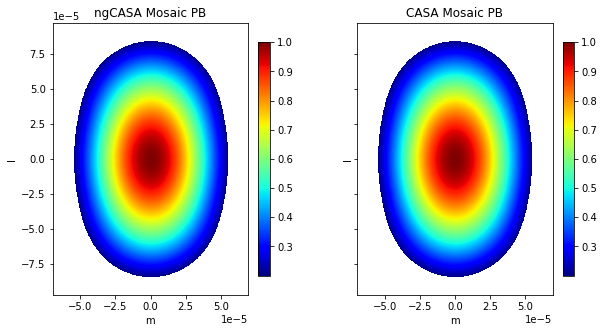

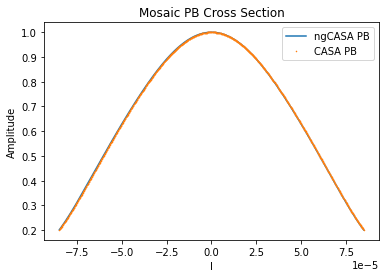

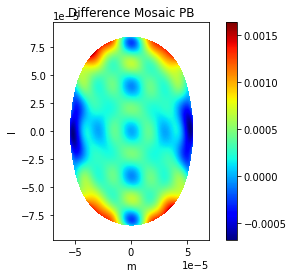

In [9]:
import matplotlib.pylab as plt
import numpy as np
from ipywidgets import interactive
import scipy
from scipy.signal import decimate
from cngi.image import implot

img_xds = xr.open_zarr('mosaic_img.img.zarr').isel(time=0,pol=0)
casa_img_xds = xr.open_zarr('alma12m_3field_dovpTrue_gridder_mosaic.img.zarr').isel(time=0,pol=0)
pb_limit = 0.2
extent = extent=(np.min(casa_img_xds.m),np.max(casa_img_xds.m),np.min(casa_img_xds.l),np.max(casa_img_xds.l))

def comparison_plots(chan):
    plt.close('all')
    print('Frequency',img_xds.chan[chan].values/10**9, 'GHz')
    mosaic_pb = img_xds.PB.isel(chan=chan)
    mosaic_pb = mosaic_pb.where(mosaic_pb > pb_limit,other=np.nan)
    
    casa_mosaic_pb = casa_img_xds.PB.isel(chan=chan)
    casa_mosaic_pb = casa_mosaic_pb.where(casa_mosaic_pb > pb_limit,other=np.nan)
    
    fig0, ax0 = plt.subplots(1, 2, sharey=True,figsize=(10, 5))
    im0 = ax0[0].imshow(mosaic_pb,extent=extent,cmap='jet')
    im1 = ax0[1].imshow(casa_mosaic_pb,extent=extent,cmap='jet')
    ax0[0].title.set_text('ngCASA Mosaic PB')
    ax0[1].title.set_text('CASA Mosaic PB')
    ax0[0].set_xlabel('m'), ax0[1].set_xlabel('m'), ax0[0].set_ylabel('l'), ax0[1].set_ylabel('l')
    fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
    fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
    
    plt.figure()
    plt.plot(casa_mosaic_pb.l,mosaic_pb.isel(m=360),label='ngCASA PB')
    plt.plot(casa_mosaic_pb.l,casa_mosaic_pb.isel(m=360),'*',label='CASA PB',markersize=1)
    plt.legend()
    plt.xlabel('l')
    plt.ylabel('Amplitude')
    plt.title('Mosaic PB Cross Section')
    
    diff_image = mosaic_pb - casa_mosaic_pb
    
    plt.figure()
    plt.imshow(mosaic_pb - casa_mosaic_pb,extent=extent,cmap='jet')
    plt.xlabel('m'), plt.ylabel('l')
    plt.colorbar()
    plt.title('Difference Mosaic PB')
    
    plt.show()

#interactive_plot = interactive(comparison_plots, chan=(0, 2))
#output = interactive_plot.children[-1]
#output.layout.auto_scroll_threshold = 9999;
#interactive_plot
comparison_plots(1)


## Get Simulated Sources l,m Coordinates

In [10]:
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
rad_to_deg =  180/np.pi
deg_to_rad = np.pi/180
arcsec_to_deg = 1/3600
arcsec_to_rad = np.pi/(180*3600)

phase_center = grid_parms['phase_center'] 
w = WCS(naxis=2)
w.wcs.crpix = np.array(grid_parms['image_size'])//2
w.wcs.cdelt = np.array([-0.04,0.04])*arcsec_to_deg
w.wcs.crval = phase_center*rad_to_deg
w.wcs.ctype = ['RA---SIN','DEC--SIN']

ra = ['12h01m51.903005s','12h01m52.430856s','12h01m52.958707s','12h01m52.259s','12h01m52s','12h01m53.153s']
dec = ['-18d51m49.94373s','-18d51m49.94369s','-18d51m49.94365s','-18d51m42.983s','-18d51m46s','-18d51m59.305s']
ps_skycoord = SkyCoord(ra=ra,dec=dec,frame='fk5')


ra_dec = np.array([ps_skycoord.ra.degree,ps_skycoord.dec.degree]).T
lm_pix_pos = w.all_world2pix(ra_dec, 1)

cell_size = np.array(grid_parms['cell_size'])*arcsec_to_rad
cell_size[0] = -cell_size[0]
image_center = np.array(grid_parms['image_size'])//2
source_lm_pos = lm_pix_pos*cell_size - image_center*cell_size


## Compare CASA and ngCASA Sky Images

Frequency 374.0 GHz
################## Flux of Point Sources ##################
Sim     ngCASA   CASA
1.500   1.4935   1.4909
1.760   1.7518   1.7458
2.000   1.9950   1.9913
2.000   2.0391   2.0546
1.456   1.4630   1.4686
1.888   1.8954   1.8425
############ Percentage Difference Flux to Sim ############
ngCASA   CASA
0.4325   0.6079
0.4672   0.8043
0.2492   0.4330
-1.9533   -2.7304
-0.4825   -0.8683
-0.3894   2.4083


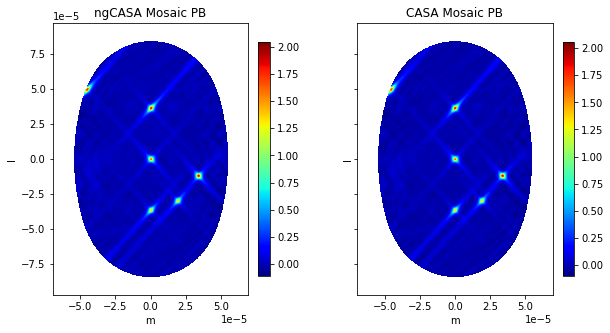

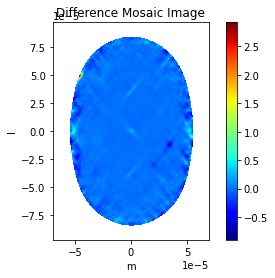

In [11]:
import matplotlib.pylab as plt
import numpy as np
from ipywidgets import interactive
import scipy
from scipy.signal import decimate

img_xds = xr.open_zarr('mosaic_img.img.zarr',chunks={'l':grid_parms['image_size'][0],'m':grid_parms['image_size'][1]}).isel(time=0,pol=0)
casa_img_xds = xr.open_zarr('alma12m_3field_dovpTrue_gridder_mosaic.img.zarr',chunks={'l':grid_parms['image_size'][0],'m':grid_parms['image_size'][1]}).isel(time=0,pol=0)
pb_limit = 0.2
extent = extent=(np.min(casa_img_xds.m),np.max(casa_img_xds.m),np.min(casa_img_xds.l),np.max(casa_img_xds.l))

ngcasa_image_name = 'IMAGE'
casa_image_name = 'IMAGE_PBCOR'

def comparison_plots(chan):
    print('Frequency',img_xds.chan[chan].values/10**9, 'GHz')
    mosaic_pb = img_xds.PB.isel(chan=chan)
    casa_mosaic_pb = casa_img_xds.PB.isel(chan=chan)
    
    mosaic_img = img_xds[ngcasa_image_name].isel(chan=chan)
    mosaic_img = mosaic_img.where(mosaic_pb > pb_limit,other=np.nan)
    
    casa_mosaic_img = casa_img_xds[casa_image_name].isel(chan=chan)
    casa_mosaic_img = casa_mosaic_img.where(casa_mosaic_pb > pb_limit,other=np.nan)
    
    sim_sources = np.array([1.5,1.76,2.0,2.0,1.456,1.888])
     
    print('################## Flux of Point Sources ##################')
    print('Sim    ','ngCASA  ', 'CASA')
    for i,s in enumerate(sim_sources):
        ngcasa_recovered_val = img_xds[ngcasa_image_name].isel(chan=chan).interp(l=source_lm_pos[i,0],m=source_lm_pos[i,1]).values
        casa_recovered_val = casa_mosaic_img.interp(l=source_lm_pos[i,0],m=source_lm_pos[i,1]).values      
        print('{0:.3f}  '.format(s),'{0:.4f}  '.format(ngcasa_recovered_val),'{0:.4f}'.format(casa_recovered_val))
    

    print('############ Percentage Difference Flux to Sim ############')
    print('ngCASA  ', 'CASA')
    for i,s in enumerate(sim_sources):
        ngcasa_recovered_val = img_xds[ngcasa_image_name].isel(chan=chan).interp(l=source_lm_pos[i,0],m=source_lm_pos[i,1]).values
        casa_recovered_val = casa_mosaic_img.interp(l=source_lm_pos[i,0],m=source_lm_pos[i,1]).values      
        print('{0:.4f}  '.format(100*(s-ngcasa_recovered_val)/s),'{0:.4f}'.format(100*(s-casa_recovered_val)/s))

    fig0, ax0 = plt.subplots(1, 2, sharey=True,figsize=(10, 5))
    im0 = ax0[0].imshow(mosaic_img,cmap='jet',extent=extent)
    im1 = ax0[1].imshow(casa_mosaic_img,cmap='jet',extent=extent)
    ax0[0].set_xlabel('m'), ax0[1].set_xlabel('m'), ax0[0].set_ylabel('l'), ax0[1].set_ylabel('l')
    ax0[0].title.set_text('ngCASA Mosaic PB')
    ax0[1].title.set_text('CASA Mosaic PB')
    fig0.colorbar(im0, ax=ax0[0], fraction=0.046, pad=0.04)
    fig0.colorbar(im1, ax=ax0[1], fraction=0.046, pad=0.04)
    
    plt.figure()
    plt.imshow((100*(mosaic_img - casa_mosaic_img)/2),cmap='jet',extent=extent)
    plt.colorbar()
    plt.xlabel('m'), plt.ylabel('l')
    plt.title('Difference Mosaic Image')
    
    plt.show()

#interactive_plot = interactive(comparison_plots, chan=(0, 2))
#output = interactive_plot.children[-1]
#output.layout.height = '1450px'
#interactive_plot
comparison_plots(1)
